## Import Library 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from scipy.signal import butter, filtfilt, iirnotch, welch
from scipy.stats import entropy, skew, kurtosis, mode
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ConfusionMatrixDisplay
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Import Dataset

In [3]:
df = pd.read_csv('Dataset/farel.csv')
label = pd.read_csv('Dataset/label.csv')
df.head()

,timestamps,TP9,AF7,AF8,TP10,Right AUX
0,1.763459e+09,-462.891,-1000.000,-888.184,-241.211,0.0
1,1.763459e+09,-535.156,-1000.000,-1000.000,-222.656,0.0
2,1.763459e+09,-475.586,-246.582,-531.250,-63.965,0.0
3,1.763459e+09,-274.414,999.512,864.258,145.020,0.0
4,1.763459e+09,-364.258,237.793,142.578,-73.730,0.0


In [4]:
label.head()

,Timestamp,Nama Lengkap,Email,Jenis Kelamin,Umur,Video ID,Rating,Confidence Score,Submitted At
0,18/11/2025 12:57:30,Athallah Azhar Aulia Hadi,athallah23004@mail.unpad.ac.id,Laki-laki,20,video_6,Biasa Saja,5,2025-11-18T05:57:27.728Z
1,18/11/2025 12:59:10,Athallah Azhar Aulia Hadi,athallah23004@mail.unpad.ac.id,Laki-laki,20,video_7,Biasa Saja,4,2025-11-18T05:59:08.355Z
2,18/11/2025 12:59:11,Athallah Azhar Aulia Hadi,athallah23004@mail.unpad.ac.id,Laki-laki,20,video_7,Biasa Saja,4,2025-11-18T05:59:09.518Z
3,18/11/2025 13:00:53,Athallah Azhar Aulia Hadi,athallah23004@mail.unpad.ac.id,Laki-laki,20,video_8,Menarik,4,2025-11-18T06:00:51.347Z
4,18/11/2025 13:02:36,Athallah Azhar Aulia Hadi,athallah23004@mail.unpad.ac.id,Laki-laki,20,video_5,Biasa Saja,4,2025-11-18T06:02:34.550Z


In [5]:
label['Nama Lengkap'].value_counts()

Nama Lengkap
Muhammad Luthfi Aziz Sunarya    14
Farrel Liesdia Putra            14
Athallah Azhar Aulia Hadi       12
Luthfi Hamam Arsyada            12
Name: count, dtype: int64

In [6]:
label = label.drop_duplicates(subset=["Nama Lengkap", "Video ID"], keep="first").reset_index(drop=True)

## Ubah Timestamps sesuai dengan yang dibutuhkan

In [7]:
def timestamp_preprocess(df):
    df['timestamps'] = pd.to_datetime(df['timestamps'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta')
    df['timestamps'] = df['timestamps'].dt.floor('S')
    df['timestamps'] = pd.to_datetime(df['timestamps'], errors='coerce')
    return df

df = timestamp_preprocess(df)

C:\Users\Danish\AppData\Local\Temp\ipykernel_13548\1820452032.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamps'] = df['timestamps'].dt.floor('S')


## Cek Rentang Timestamps

In [8]:
def rentang(df):
    min_time = df['timestamps'].min()
    max_time = df['timestamps'].max()

    rentang_waktu = max_time - min_time

    print("Rentang timestamps:")
    print("Dari :", min_time)
    print("Sampai:", max_time)
    print("Durasi rentang:", rentang_waktu)

    return rentang_waktu.total_seconds()

In [9]:
rentang(df)

Rentang timestamps:
Dari : 2025-11-18 16:37:20+07:00
Sampai: 2025-11-18 16:55:18+07:00
Durasi rentang: 0 days 00:17:58


1078.0

In [10]:
def assign_eeg_labels(eeg_df, label_df, nama_lengkap):
    # Filter label sesuai nama
    person_labels = label_df[label_df["Nama Lengkap"] == nama_lengkap].reset_index(drop=True)
    jumlah_video = len(person_labels)

    # Hitung total durasi dataset (detik)
    min_time = eeg_df['timestamps'].min()
    max_time = eeg_df['timestamps'].max()
    total_duration = (max_time - min_time).total_seconds()

    # 1. Baseline awal fixed 38 detik
    baseline_awal = 38

    # 2. Sisa waktu dibagi rata ke masing-masing video-block
    remaining_time = total_duration - baseline_awal
    video_block = remaining_time / jumlah_video  # total 1 blok (video + rest)

    durasi_video = 60
    durasi_rest = video_block - durasi_video  # istirahat per video (akhir)

    print("Total durasi dataset:", total_duration)
    print("Durasi blok per video:", video_block)
    print("Durasi istirahat akhir:", durasi_rest)

    # Inisialisasi kolom
    eeg_df["video_id"] = None
    eeg_df["rating"] = None
    eeg_df["confidence"] = None

    # Start timestamp
    current_time = min_time

    # Beri label BASELINE AWAL 38 detik
    rest1_end = current_time + timedelta(seconds=baseline_awal)
    eeg_df.loc[
        (eeg_df["timestamps"] >= current_time) &
        (eeg_df["timestamps"] < rest1_end),
        ["video_id", "rating", "confidence"]
    ] = ["Istirahat", "Istirahat", "Istirahat"]

    current_time = rest1_end

    # Loop per video
    for i, row in person_labels.iterrows():

        # VIDEO 60 detik
        vid_start = current_time
        vid_end = current_time + timedelta(seconds=durasi_video)

        eeg_df.loc[
            (eeg_df["timestamps"] >= vid_start) &
            (eeg_df["timestamps"] < vid_end),
            ["video_id", "rating", "confidence"]
        ] = [
            row["Video ID"], 
            row["Rating"], 
            row["Confidence Score"]
        ]

        current_time = vid_end

        # ISTIRAHAT AKHIR (durasi_rest)
        rest2_end = current_time + timedelta(seconds=durasi_rest)

        eeg_df.loc[
            (eeg_df["timestamps"] >= current_time) &
            (eeg_df["timestamps"] < rest2_end),
            ["video_id", "rating", "confidence"]
        ] = ["Istirahat", "Istirahat", "Istirahat"]

        current_time = rest2_end

    eeg_df = eeg_df.dropna(subset=["video_id"])
    return eeg_df

In [11]:
df = assign_eeg_labels(df, label, "Farrel Liesdia Putra")

Total durasi dataset: 1078.0
Durasi blok per video: 104.0
Durasi istirahat akhir: 44.0


In [12]:
df['video_id'].value_counts()

video_id
Istirahat    122373
video_6       15373
video_1       15373
video_9       15373
video_10      15373
video_2       15373
video_4       15373
video_7       15372
video_5       15372
video_8       15372
video_3       15372
Name: count, dtype: int64

In [13]:
rentang(df)

Rentang timestamps:
Dari : 2025-11-18 16:37:20+07:00
Sampai: 2025-11-18 16:55:17+07:00
Durasi rentang: 0 days 00:17:57


1077.0

In [14]:
df['rating'].unique()

array(['Istirahat', 'Biasa Saja', 'Menarik', 'Tidak Menarik'],
      dtype=object)

In [15]:
df['confidence'] = df['confidence'].replace('Istirahat', 0)
df['video_id'] = df['video_id'].str.replace('video_', '', regex=False).replace('Istirahat', 0)
df['rating'] = df['rating'].map({'Istirahat': 0, 'Tidak Menarik': 1, 'Biasa Saja': 2, 'Menarik': 3})

C:\Users\Danish\AppData\Local\Temp\ipykernel_13548\4169327550.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['confidence'] = df['confidence'].replace('Istirahat', 0)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276099 entries, 0 to 276098
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype                       
---  ------      --------------   -----                       
 0   timestamps  276099 non-null  datetime64[ns, Asia/Jakarta]
 1   TP9         276099 non-null  float64                     
 2   AF7         276099 non-null  float64                     
 3   AF8         276099 non-null  float64                     
 4   TP10        276099 non-null  float64                     
 5   Right AUX   276099 non-null  float64                     
 6   video_id    276099 non-null  object                      
 7   rating      276099 non-null  int64                       
 8   confidence  276099 non-null  int64                       
dtypes: datetime64[ns, Asia/Jakarta](1), float64(5), int64(2), object(1)
memory usage: 21.1+ MB


In [17]:
df.describe()

,TP9,AF7,AF8,TP10,Right AUX,rating,confidence
count,276099.000000,276099.000000,276099.000000,276099.000000,276099.0,276099.000000,276099.000000
mean,-15.895176,75.217474,64.415600,96.473621,0.0,0.946519,2.394159
std,121.429361,790.574967,765.188397,779.284118,0.0,1.026068,2.239182
min,-1000.000000,-1000.000000,-1000.000000,-1000.000000,0.0,0.000000,0.000000
25%,-76.172000,-794.434000,-742.676000,-722.656000,0.0,0.000000,0.000000
50%,-4.395000,194.824000,97.168000,215.332000,0.0,1.000000,3.000000
75%,43.457000,938.232500,872.559000,937.012000,0.0,2.000000,5.000000
max,999.512000,999.512000,999.512000,999.512000,0.0,3.000000,5.000000


In [18]:
df

,timestamps,TP9,AF7,AF8,TP10,Right AUX,video_id,rating,confidence
0,2025-11-18 16:37:20+07:00,-462.891,-1000.000,-888.184,-241.211,0.0,0,0,0
1,2025-11-18 16:37:20+07:00,-535.156,-1000.000,-1000.000,-222.656,0.0,0,0,0
2,2025-11-18 16:37:20+07:00,-475.586,-246.582,-531.250,-63.965,0.0,0,0,0
3,2025-11-18 16:37:20+07:00,-274.414,999.512,864.258,145.020,0.0,0,0,0
4,2025-11-18 16:37:20+07:00,-364.258,237.793,142.578,-73.730,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...
276094,2025-11-18 16:55:17+07:00,0.000,999.512,999.512,999.512,0.0,0,0,0
276095,2025-11-18 16:55:17+07:00,135.254,503.906,7.324,694.824,0.0,0,0,0
276096,2025-11-18 16:55:17+07:00,-67.871,-903.320,-1000.000,-757.812,0.0,0,0,0
276097,2025-11-18 16:55:17+07:00,-154.297,-1000.000,-756.348,-1000.000,0.0,0,0,0


In [20]:
if "Right AUX" in df.columns:
    df = df.drop(columns=["Right AUX"])

In [26]:
# Bandpass Filter
fs = 256
lowcut = 1
highcut = 40

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def apply_bandpass(data):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data)

In [27]:
# Notch Filter
def apply_notch(data, freq=50, Q=30):
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

In [29]:
# Apply filtering to all EEG channels
eeg_channels = [col for col in df.columns if col not in ["timestamps", 'video_id', 'rating','confidence']]

for ch in eeg_channels:
    df[ch] = apply_bandpass(df[ch])
    df[ch] = apply_notch(df[ch])

In [30]:
df

,timestamps,TP9,AF7,AF8,TP10,video_id,rating,confidence
0,2025-11-18 16:37:20+07:00,6.823522,55.821839,-95.845933,30.480117,0,0,0
1,2025-11-18 16:37:20+07:00,15.427402,633.384390,418.843202,137.449801,0,0,0
2,2025-11-18 16:37:20+07:00,27.453976,1014.207669,757.816184,206.380867,0,0,0
3,2025-11-18 16:37:20+07:00,43.964160,1078.375952,773.516826,219.921388,0,0,0
4,2025-11-18 16:37:20+07:00,62.316875,950.174812,518.372910,199.922209,0,0,0
...,...,...,...,...,...,...,...,...
276094,2025-11-18 16:55:17+07:00,-13.504753,-421.624019,-640.777760,-365.849195,0,0,0
276095,2025-11-18 16:55:17+07:00,-26.996021,-500.502067,-776.121599,-414.106639,0,0,0
276096,2025-11-18 16:55:17+07:00,-29.821771,-492.661045,-772.786605,-390.988779,0,0,0
276097,2025-11-18 16:55:17+07:00,-16.235099,-326.755626,-521.369604,-253.815868,0,0,0


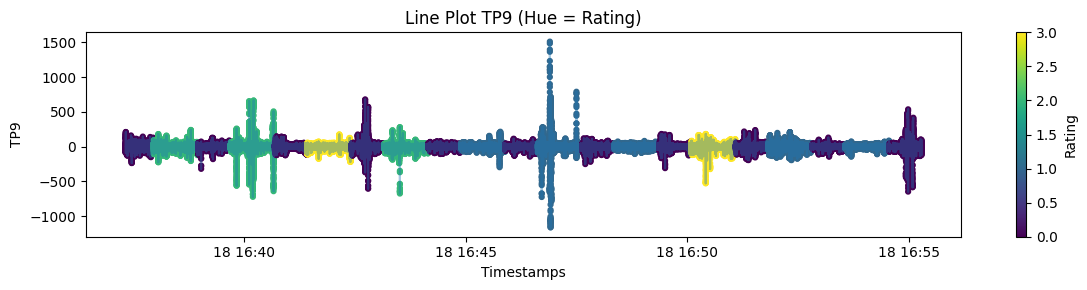

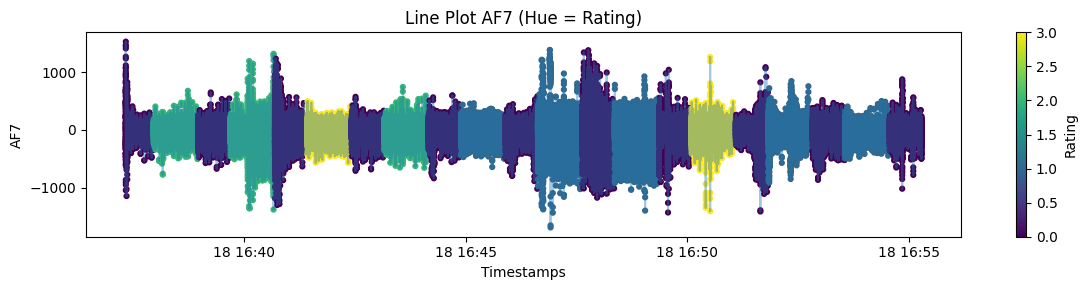

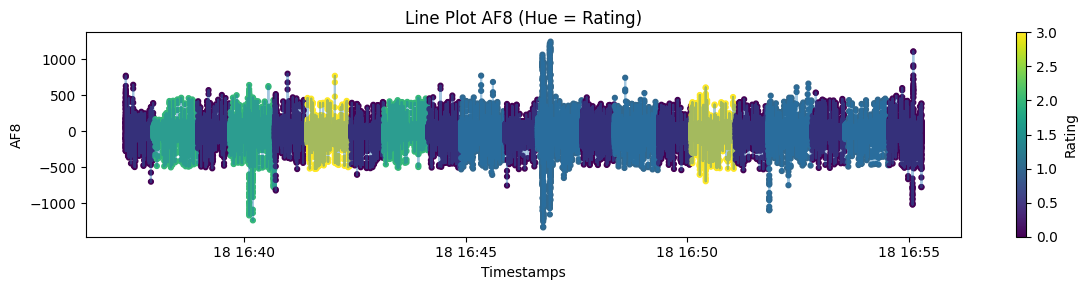

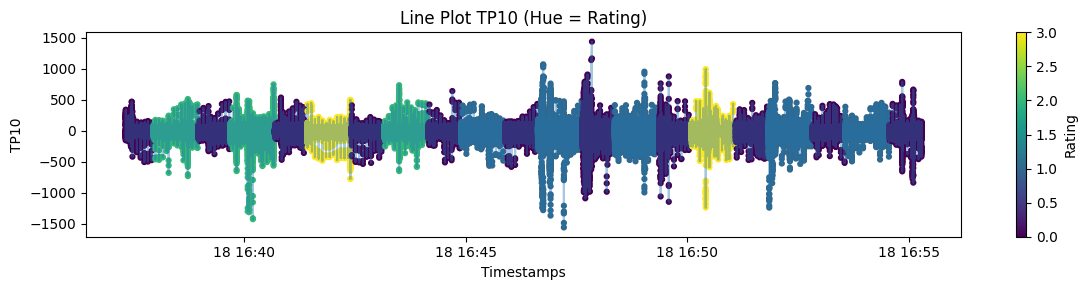

In [31]:
value_cols = [
    col for col in df.columns 
    if col not in ['timestamps', 'rating', 'video_id', 'confidence'] 
       and np.issubdtype(df[col].dtype, np.number)
]

for col in value_cols:
    plt.figure(figsize=(12, 3))

    plt.plot(df['timestamps'], df[col], alpha=0.4)

    scatter = plt.scatter(
        df['timestamps'],
        df[col],
        c=df['rating'],
        cmap='viridis',     
        s=12
    )

    plt.title(f"Line Plot {col} (Hue = Rating)")
    plt.xlabel("Timestamps")
    plt.ylabel(col)

    cbar = plt.colorbar(scatter)
    cbar.set_label("Rating")

    plt.tight_layout()
    plt.show()

In [32]:
# Normalization (z-score)
for ch in eeg_channels:
    df[ch] = (df[ch] - df[ch].mean()) / df[ch].std()

In [33]:
# Optional smoothing (rolling mean)
for ch in eeg_channels:
    df[ch] = df[ch].rolling(window=5, min_periods=1).mean()